In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec

import re

from matplotlib.patches import Rectangle

## Load the data

In [2]:
doc_info = pd.read_csv('../data/0c_doc_info.csv')

impact_df = pd.read_csv('../data/1_impact_predictions.csv')
driver_df = pd.read_csv('../data/1_driver_predictions.csv')
predictions = pd.read_csv('../data/1_document_relevance.csv')

df = driver_df.merge(impact_df).merge(predictions).merge(doc_info)
print(df.shape)

doc_continents = pd.read_csv('../data/doc_continents.csv').merge(pd.read_csv('../data/1_document_relevance.csv'), left_on="doc_id",right_on="id")
doc_continents.head()

df.head()


(163853, 43)


,id,6 - Temperature - mean_prediction,6 - Temperature - std_prediction,6 - Temperature - lower_pred,6 - Temperature - upper_pred,6 - Precipitation - mean_prediction,6 - Precipitation - std_prediction,6 - Precipitation - lower_pred,6 - Precipitation - upper_pred,6 - Other - mean_prediction,...,12 - Other systems - mean_prediction,12 - Other systems - lower_pred,12 - Other systems - upper_pred,0 - relevance - mean_prediction,0 - relevance - std_prediction,0 - relevance - lower_pred,0 - relevance - upper_pred,PY,title,wosarticle__dt
0,1300115,0.599319,0.123371,0.475948,0.722689,0.039122,0.007976,0.031147,0.047098,0.438100,...,0.145983,0.068096,0.223870,0.898821,0.094973,0.803848,0.993795,2018.0,Oceanographic mechanisms and penguin populatio...,Article
1,626619,0.163634,0.046660,0.116974,0.210294,0.244802,0.041110,0.203692,0.285913,0.634133,...,0.449128,0.342320,0.555937,0.503902,0.382881,0.121021,0.886782,2001.0,Effect of basin physical characteristics on so...,Article
2,3910065,0.276482,0.167964,0.108517,0.444446,0.765776,0.082619,0.683157,0.848395,0.224603,...,0.256394,0.146847,0.365941,0.428647,0.292183,0.136463,0.720830,2018.0,Evaluation of the Oceanic Niño Index as a deci...,Article
3,2317601,0.613144,0.223667,0.389477,0.836811,0.183233,0.014026,0.169207,0.197258,0.300958,...,0.679061,0.530263,0.827860,0.794071,0.135684,0.658387,0.929755,2017.0,The Impact of Wind on the Economic Activities ...,Article
4,618304,0.867647,0.054082,0.813565,0.921728,0.036531,0.008577,0.027954,0.045109,0.137281,...,0.335643,0.236926,0.434360,0.970139,0.012548,0.957591,0.982688,2011.0,Warming alters the size spectrum and shifts th...,Article


In [3]:
for v in ['0 - relevance - mean_prediction','0 - relevance - upper_pred','0 - relevance - lower_pred']:
    print(v)
    print(df[df[v]>=0.5].groupby(['wosarticle__dt'])['wosarticle__dt'].count().sort_values(ascending=False).head())

0 - relevance - mean_prediction
wosarticle__dt
Article              86018
JOUR                  3772
Review                3012
Proceedings Paper     2103
Conference Paper      1686
Name: wosarticle__dt, dtype: int64
0 - relevance - upper_pred
wosarticle__dt
Article              137022
Review                 5757
JOUR                   5613
Proceedings Paper      3393
Conference Paper       2962
Name: wosarticle__dt, dtype: int64
0 - relevance - lower_pred
wosarticle__dt
Article              54475
JOUR                  2534
Review                1635
Proceedings Paper     1308
Conference Paper       973
Name: wosarticle__dt, dtype: int64


In [4]:
df.groupby(['wosarticle__dt'])['wosarticle__dt'].count().sort_values(ascending=False).head()

wosarticle__dt
Article              137022
Review                 5757
JOUR                   5613
Proceedings Paper      3393
Conference Paper       2962
Name: wosarticle__dt, dtype: int64

In [5]:
(3393+2962)/df.shape[0]

0.03878476439247374

0.5641895835477563
0.18456063729511282
0.2948002005274155
0.23247903843315937
0.03730106508944715
0.01362689522646478
(-0.079135002979485, 1.0791350029794848)


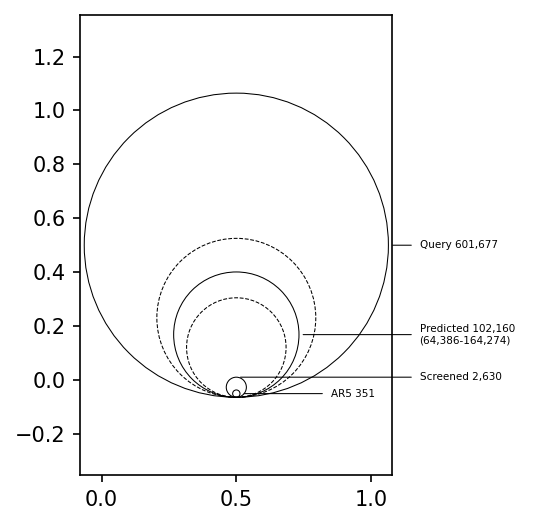

In [6]:
from matplotlib.patches import Circle
import math

predictions = pd.read_csv('../data/1_document_relevance.csv')
seen_df = pd.read_csv('../data/0_labelled_documents.csv')

fig, ax = plt.subplots(dpi=150, figsize=(3.6,3.6))

query_size = predictions.shape[0]
predicted_size = predictions[predictions['0 - relevance - mean_prediction']>0.5].shape[0]
upper_pred_size = predictions[predictions['0 - relevance - upper_pred']>0.5].shape[0]
lower_pred_size = predictions[predictions['0 - relevance - lower_pred']>0.5].shape[0]
screened_size = seen_df.shape[0]
ar5 = pd.read_csv('../literature_identification/IPCC_extraction.csv')
ar5_size = ar5.shape[0]

max_area = query_size

cols=["black","black","black","black"]
fill_cols = ['#7fc97f','#beaed4','#fdc086','#ffff99']

fill_cols = ["None"] * 4

fill_cols.reverse()
lw = .5

def draw_circle(label, size, max_size, ax, col, max_r=None, ytop=False, dotted=False, bounds="",label_offset=1.18):
    r = math.sqrt(size/max_size/math.pi)
    print(r)
    if dotted:
        ls = "--"
    else:
        ls = "-"
    if max_r is None:
        max_r = r
        y = 0.5
    else:
        y = 0.5-(max_r-r)
    circle = Circle(
        (0.5,y), r,
        color=col,
        ec="black",
        lw=lw,
        ls=ls,
        clip_on=False
    )
    ax.add_patch(circle)
    if ytop:
        ylab = y+r
        xlab = 0.5
    else:
        ylab = y
        xlab = 0.5+r
    if label:
        ax.annotate(
            f"{label} {size:,} {bounds}", (xlab,ylab), (label_offset,ylab), 
            arrowprops={"arrowstyle": "-",  "linewidth":0.5}, va="center",
            fontsize=5, annotation_clip=False
        )
    return r

#Query docs
max_r = draw_circle("Query", query_size, query_size, ax, fill_cols[0])
r = draw_circle(None, lower_pred_size, query_size, ax, fill_cols[1], max_r, dotted=True)
r = draw_circle(None, upper_pred_size, query_size, ax, fill_cols[1], max_r, dotted=True)
r = draw_circle("Predicted", predicted_size, query_size, ax, fill_cols[1], max_r, bounds=f"\n({lower_pred_size:,}-{upper_pred_size:,})")
r = draw_circle("Screened", screened_size, query_size, ax, fill_cols[2], max_r, True)
r = draw_circle("AR5", ar5_size, query_size, ax, fill_cols[3], max_r, False, label_offset=0.85)

ax.axis('equal')
ax.margins(0)
#ax.axis('off')

fig.tight_layout()

print(ax.get_xlim())

plt.show()

FAR
802 (457-1452)
SAR
2106 (1208-3534)
TAR
5009 (2985-8412)
AR4
10447 (6700-16707)
AR5
28513 (17832-45077)
AR6
46442 (34473-87861)
0.5641895835477563
0.18456063729511282
0.2948002005274155
0.23247903843315937
0.03730106508944715
0.01362689522646478
12 - Coastal and marine Ecosystems - mean_prediction
12607 5795 25383
12 - Human and managed - mean_prediction
12186 6523 26140
12 - Mountains, snow and ice - mean_prediction
6307 3526 12228
12 - Rivers, lakes, and soil moisture - mean_prediction
12805 7055 25161
12 - Terrestrial ES - mean_prediction
34988 18520 65666
12 - Other systems - mean_prediction
23603 9557 55701


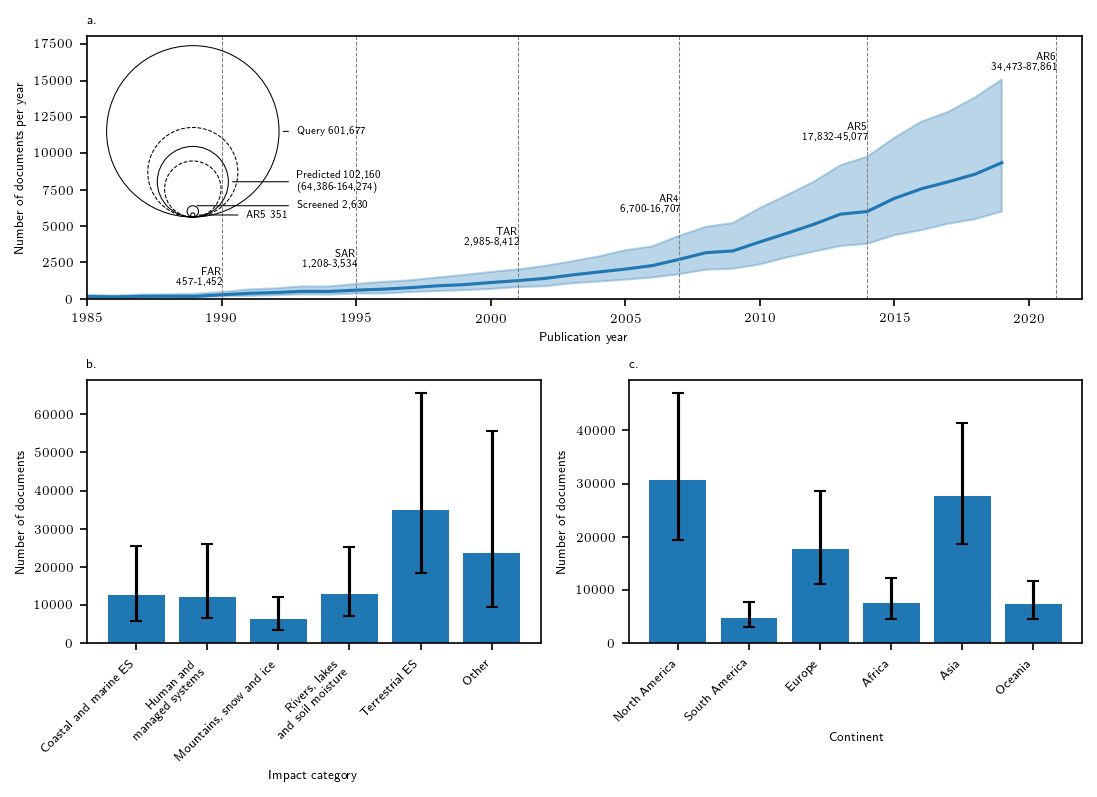

In [7]:
fig = plt.figure(figsize=(7.2,5.2), dpi=150, constrained_layout=True)
gs = fig.add_gridspec(6, 6)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
})

#########################
## Time+uncertainty
ax = plt.subplot(gs[:3,0:])


lb = df[df['0 - relevance - lower_pred']>0.5].groupby('PY')['id'].size().to_frame().reset_index().rename(columns={"id":"lb"})
mid = df[df['0 - relevance - mean_prediction']>0.5].groupby('PY')['id'].size().to_frame().reset_index().rename(columns={"id":"mid"})
ub = df[df['0 - relevance - upper_pred']>0.5].groupby('PY')['id'].size().to_frame().reset_index().rename(columns={"id":"ub"})

mid = mid[mid['PY']<2020]

bounds = lb.merge(ub, how="outer")

bounds = bounds[bounds['PY']<2020]

ax.plot(mid['PY'], mid['mid'], color="C0")

ax.fill_between(
    bounds['PY'], bounds['lb'], bounds['ub'],
    color="C0",
    alpha=0.3
)

ax.set_xlim([1985,2019])

ax.set_xlabel('Publication year', fontsize=6)
ax.set_ylabel('Number of documents per year', fontsize=6)

ax.tick_params(axis='both', labelsize=6) 

report_dates = [1990, 1995, 2001, 2007, 2014, 2021]
report_labels = ["FAR", "SAR", "TAR", "AR4", "AR5", "AR6"]

ymax = ub['ub'].max()

ld = 0

offsets = [350, 1000, 1500, 1500, 1000, 500]

for i, (d, l) in enumerate(zip(report_dates, report_labels)):
    #idx = py_range.index(d)
    print(l)
    # bounds for this reporting period
    r_m = mid[mid['PY'].isin(range(ld,d))]['mid'].sum()
    r_lb = lb[lb['PY'].isin(range(ld,d))]['lb'].sum()
    r_ub = ub[ub['PY'].isin(range(ld,d))]['ub'].sum()
    
    print(f"{r_m} ({r_lb}-{r_ub})")
    

    
    if l=="AR6":
        y = ub.ub.max()
        ty = y+offsets[i]
        ax.axvline(d, color="grey",lw=0.5, ls="--")
        ax.text(d, ty, f"{l}\n{r_lb:,}-{r_ub:,}", va="bottom", ha="right", fontsize=5)
    else:
        y = ub[ub['PY']==d].ub.values[0]
        ty = y+offsets[i]
        ax.axvline(d, color="grey",lw=0.5, ls="--")
        ax.text(d, ty, f"{l}\n{r_lb:,}-{r_ub:,}", va="bottom", ha="right", fontsize=5)

    ld=d

ax.set_xlim([1985,2022])
ax.set_ylim([0,ymax*1.2])
ax.set_title("a.", fontsize=6, loc="left", fontweight="black")


####################
## 
# Inset axis 
ax = ax.inset_axes([0.00,0.4,0.32,0.6])
fill_cols = ["None"] * 4

#Query docs
max_r = draw_circle("Query", query_size, query_size, ax, fill_cols[0])
r = draw_circle(None, lower_pred_size, query_size, ax, fill_cols[1], max_r, dotted=True)
r = draw_circle(None, upper_pred_size, query_size, ax, fill_cols[1], max_r, dotted=True)
r = draw_circle("Predicted", predicted_size, query_size, ax, fill_cols[1], max_r, bounds=f"\n({lower_pred_size:,}-{upper_pred_size:,})")
r = draw_circle("Screened", screened_size, query_size, ax, fill_cols[2], max_r, True)
r = draw_circle("AR5", ar5_size, query_size, ax, fill_cols[3], max_r, False, label_offset=0.85)

ax.axis('equal')
ax.axis('off')
ax.set_xlim(xmin=0.4, xmax=1.3)
ax.set_ylim(ymin=0.1)



######################################
##

ax = plt.subplot(gs[3:,:2])

colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3']

pred_cats = [x for x in df.columns if "12 - " in x and "mean_prediction" in x]

xticks = []
for i, c in enumerate(pred_cats):
    print(c)
    mid = df[
        (df['0 - relevance - mean_prediction']>0.5) & 
        (df[c]>0.5)
    ].shape[0]
    ub = df[
        (df['0 - relevance - upper_pred']>0.5) & 
        (df[c.replace('mean_prediction','upper_pred')]>0.5)
    ].shape[0]
    lb = df[
        (df['0 - relevance - lower_pred']>0.5) & 
        (df[c.replace('mean_prediction','lower_pred')]>0.5)
    ].shape[0]
    
    print(mid, lb, ub)
    
    #ax.bar(i, mid,color=colors[i])
    ax.bar(i, mid, color="C0")
    
    eay = np.array([[mid-lb, ub-mid]]).T
    
    ax.errorbar(i, mid, yerr=eay, color="black", capsize=3,zorder=5)
    
    xticks.append(c.split("-")[1].strip())
    
ax.set_xticks(range(i+1))
ax.tick_params(axis='both', labelsize=6) 

xticks = [
    "Coastal and marine ES",
    "Human and\nmanaged systems",      
    "Mountains, snow and ice",
    "Rivers, lakes\n and soil moisture",
    "Terrestrial ES",
    "Other"
  
]
ax.set_xticklabels(xticks, rotation=45,ha="right")
ax.set_title("b.", fontsize=6, loc="left", fontweight="black")
ax.set_xlabel('Impact category', fontsize=6)
ax.set_ylabel('Number of documents', fontsize=6)


######################################
##

ax = plt.subplot(gs[3:,4:6])

cons = ["North America", "South America", "Europe","Africa", "Asia", "Oceania"]

for i, con in enumerate(cons):
    cdf = df[df['id'].isin(doc_continents.loc[doc_continents['continent']==con,"doc_id"])]
    mid = cdf[cdf['0 - relevance - mean_prediction']>0.5].shape[0]
    ub = cdf[cdf['0 - relevance - upper_pred']>0.5].shape[0]
    lb = cdf[cdf['0 - relevance - lower_pred']>0.5].shape[0]
    
    #ax.bar(i, mid)
    ax.bar(i, mid, color="C0")
    
    eay = np.array([[mid-lb, ub-mid]]).T
    
    ax.errorbar(i, mid, yerr=eay, color="black", capsize=3)
    
ax.set_xticks(range(i+1))
ax.set_xticklabels(cons, rotation=45,ha="right")
ax.tick_params(axis='both', labelsize=6) 
ax.set_title("c.", fontsize=6, loc="left", fontweight="bold")

ax.set_xlabel('Continent', fontsize=6)
ax.set_ylabel('Number of documents', fontsize=6)

plt.savefig(f"../figures/figure_1.png", dpi=500, bbox_inches="tight")
plt.savefig(f"../figures/figure_1.svg")
plt.savefig(f"../figures/figure_1.pdf", bbox_inches="tight", usetex=True)
    

FAR
802 (457-1452)
SAR
2106 (1208-3534)
TAR
5009 (2985-8412)
AR4
10447 (6700-16707)
AR5
28513 (17832-45077)
AR6
46442 (34473-87861)
0.5641895835477563
0.18456063729511282
0.2948002005274155
0.23247903843315937
0.03730106508944715
0.01362689522646478


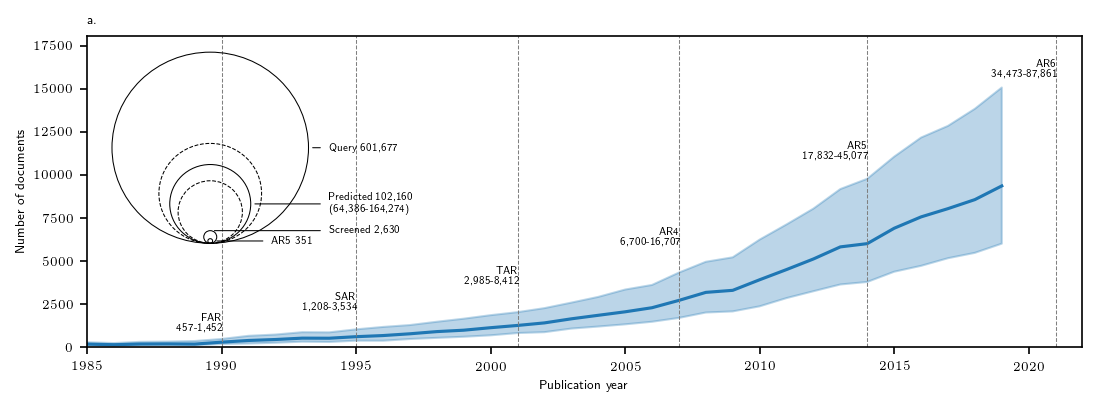

In [8]:
fig = plt.figure(figsize=(7.2,2.6), dpi=150, constrained_layout=True)
gs = fig.add_gridspec(3, 6)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
})

#########################
## Time+uncertainty
ax = plt.subplot(gs[:3,0:])


lb = df[df['0 - relevance - lower_pred']>0.5].groupby('PY')['id'].size().to_frame().reset_index().rename(columns={"id":"lb"})
mid = df[df['0 - relevance - mean_prediction']>0.5].groupby('PY')['id'].size().to_frame().reset_index().rename(columns={"id":"mid"})
ub = df[df['0 - relevance - upper_pred']>0.5].groupby('PY')['id'].size().to_frame().reset_index().rename(columns={"id":"ub"})

mid = mid[mid['PY']<2020]

bounds = lb.merge(ub, how="outer")

bounds = bounds[bounds['PY']<2020]

ax.plot(mid['PY'], mid['mid'], color="C0")

ax.fill_between(
    bounds['PY'], bounds['lb'], bounds['ub'],
    color="C0",
    alpha=0.3
)

ax.set_xlim([1985,2019])

ax.set_xlabel('Publication year', fontsize=6)
ax.set_ylabel('Number of documents', fontsize=6)

ax.tick_params(axis='both', labelsize=6) 

report_dates = [1990, 1995, 2001, 2007, 2014, 2021]
report_labels = ["FAR", "SAR", "TAR", "AR4", "AR5", "AR6"]

ymax = ub['ub'].max()

ld = 0

offsets = [350, 1000, 1500, 1500, 1000, 500]

for i, (d, l) in enumerate(zip(report_dates, report_labels)):
    #idx = py_range.index(d)
    print(l)
    # bounds for this reporting period
    r_m = mid[mid['PY'].isin(range(ld,d))]['mid'].sum()
    r_lb = lb[lb['PY'].isin(range(ld,d))]['lb'].sum()
    r_ub = ub[ub['PY'].isin(range(ld,d))]['ub'].sum()
    
    print(f"{r_m} ({r_lb}-{r_ub})")
    

    
    if l=="AR6":
        y = ub.ub.max()
        ty = y+offsets[i]
        ax.axvline(d, color="grey",lw=0.5, ls="--")
        ax.text(d, ty, f"{l}\n{r_lb:,}-{r_ub:,}", va="bottom", ha="right", fontsize=5)
    else:
        y = ub[ub['PY']==d].ub.values[0]
        ty = y+offsets[i]
        ax.axvline(d, color="grey",lw=0.5, ls="--")
        ax.text(d, ty, f"{l}\n{r_lb:,}-{r_ub:,}", va="bottom", ha="right", fontsize=5)

    ld=d

ax.set_xlim([1985,2022])
ax.set_ylim([0,ymax*1.2])
ax.set_title("a.", fontsize=6, loc="left", fontweight="black")


####################
## 
# Inset axis 
ax = ax.inset_axes([0.025,0.4,0.32,0.6])
fill_cols = ["None"] * 4

#Query docs
max_r = draw_circle("Query", query_size, query_size, ax, fill_cols[0])
r = draw_circle(None, lower_pred_size, query_size, ax, fill_cols[1], max_r, dotted=True)
r = draw_circle(None, upper_pred_size, query_size, ax, fill_cols[1], max_r, dotted=True)
r = draw_circle("Predicted", predicted_size, query_size, ax, fill_cols[1], max_r, bounds=f"\n({lower_pred_size:,}-{upper_pred_size:,})")
r = draw_circle("Screened", screened_size, query_size, ax, fill_cols[2], max_r, True)
r = draw_circle("AR5", ar5_size, query_size, ax, fill_cols[3], max_r, False, label_offset=0.85)

ax.axis('equal')
ax.axis('off')
ax.set_xlim(xmin=0.4, xmax=1.3)
ax.set_ylim(ymin=0.1)

plt.savefig(f"../figures/figure_1a.png", dpi=500, bbox_inches="tight")
plt.savefig(f"../figures/figure_1a.svg")
plt.savefig(f"../figures/figure_1a.pdf", bbox_inches="tight", usetex=True)


In [9]:
c_pops = {
    "Africa": 1308.0642,
    "North America": 366.601+43.335+177.5865,
    "South America": 427.1994,
    "Asia": 4601.3712,
    "Europe": 747.1828,
    "Oceania": 42.128
}

Text(0, 0.5, 'Number of documents per million inhabitants')

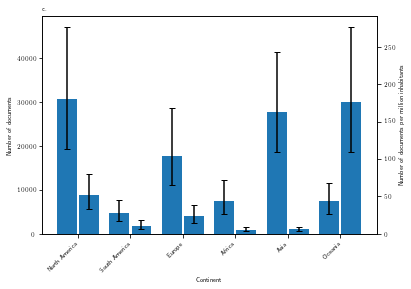

In [10]:
fig, ax = plt.subplots()

ax2 = ax.twinx()
for i, con in enumerate(cons):
    cdf = df[df['id'].isin(doc_continents.loc[doc_continents['continent']==con,"doc_id"])]
    mid = cdf[cdf['0 - relevance - mean_prediction']>0.5].shape[0] 
    ub = cdf[cdf['0 - relevance - upper_pred']>0.5].shape[0] 
    lb = cdf[cdf['0 - relevance - lower_pred']>0.5].shape[0]
    
    #ax.bar(i, mid)
    ax.bar(i-0.21, mid, color="C0",width=0.38)
    
    ax2.bar(i+0.21, mid/c_pops[con], color="C0",width=0.38)
    
    eay = np.array([[mid-lb, ub-mid]]).T
    
    ax.errorbar(i-0.21, mid, yerr=eay, color="black", capsize=3)
    
    ax2.errorbar(i+0.21, mid/c_pops[con], yerr=eay/c_pops[con], color="black", capsize=3)
    
ax.set_xticks(range(i+1))
ax.set_xticklabels(cons, rotation=45,ha="right")
ax.tick_params(axis='both', labelsize=6) 
ax2.tick_params(axis='both', labelsize=6) 
ax.set_title("c.", fontsize=6, loc="left", fontweight="bold")

ax.set_xlabel('Continent', fontsize=6)
ax.set_ylabel('Number of documents', fontsize=6)
ax2.set_ylabel('Number of documents per million inhabitants', fontsize=6)

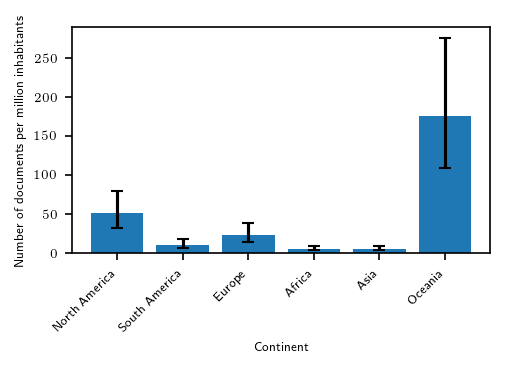

In [11]:
fig, ax = plt.subplots(figsize=(3.6,2),dpi=150)

for i, con in enumerate(cons):
    cdf = df[df['id'].isin(doc_continents.loc[doc_continents['continent']==con,"doc_id"])]
    mid = cdf[cdf['0 - relevance - mean_prediction']>0.5].shape[0] 
    ub = cdf[cdf['0 - relevance - upper_pred']>0.5].shape[0] 
    lb = cdf[cdf['0 - relevance - lower_pred']>0.5].shape[0]
    
    
    ax.bar(i, mid/c_pops[con], color="C0")
    
    eay = np.array([[mid-lb, ub-mid]]).T
        
    ax.errorbar(i, mid/c_pops[con], yerr=eay/c_pops[con], color="black", capsize=3)
    
ax.set_xticks(range(i+1))
ax.set_xticklabels(cons, rotation=45,ha="right")
ax.tick_params(axis='both', labelsize=6) 

ax.set_xlabel('Continent', fontsize=6)
ax.set_ylabel('Number of documents per million inhabitants', fontsize=6)

plt.savefig('../figures/sup_figure_1.pdf')
plt.savefig('../figures/sup_figure_1.png',dpi=300)
plt.savefig('../figures/sup_figure_1.svg')